In [1]:
# Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import zscore

# Set some options for output rendering

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('dark_background')
plt.rcParams['grid.color'] = 'white'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
warnings.filterwarnings('ignore')

# If True, processed data files and figures will be saved
save_output = False
cwd = os.getcwd()

In [2]:
# Read data and check dtypes

filename = 'finestapi_tracking_db.csv'
original_df = pd.read_csv(os.path.join(cwd, '..', 'data', 'raw', filename))

print('dtypes:\n')
print(original_df.dtypes)

dtypes:

id               int64
updated         object
ship            object
imo              int64
lat            float64
long           float64
sog            float64
cog              int64
hdg              int64
depPort         object
etdSchedule     object
etd             object
atd             object
arrPort         object
etaSchedule     object
eta             object
ata             object
dtype: object


In [3]:
# Further explore variables, with a sperarate dataframe for object dtypes

display(original_df.describe())
display(original_df.describe(include=['object']))

,id,imo,lat,long,sog,cog,hdg
count,823672.000000,8.236720e+05,823672.000000,823672.000000,823672.000000,823672.000000,823672.000000
mean,462795.350583,9.401429e+06,59.800330,24.807672,19.285331,149.432205,156.911632
std,266273.511015,2.798543e+05,0.223849,0.084678,5.956900,111.171883,110.111634
min,4136.000000,8.919805e+06,59.420800,22.382100,0.000000,0.000000,0.000000
25%,228046.500000,9.214379e+06,59.602800,24.739800,16.400000,22.000000,23.000000
50%,463107.500000,9.364722e+06,59.799500,24.802200,21.900000,180.000000,183.000000
75%,696270.250000,9.773064e+06,60.000000,24.895600,22.800000,202.000000,204.000000
max,912183.000000,9.773064e+06,60.154000,24.984800,102.300000,360.000000,511.000000


,updated,ship,depPort,etdSchedule,etd,atd,arrPort,etaSchedule,eta,ata
count,823672,823672,823672,823672,823670,816945,823670,823670,823666,6411
unique,344443,6,2,4028,4369,6087,2,4387,49805,6000
top,25/01/2019 17:47,Megastar,FIHEL,26/01/2019 16:30,24/01/2019 16:30,2019-01-26 08:21:12,EETLL,05/01/2019 07:30,27/01/2019 07:29,2019-01-22 13:27:18
freq,16,253103,418490,712,706,514,418488,532,294,4


## Task 1. Data cleaning
* ensure consistent datetime format
* drop rows with missing values
* also ensure consistent naming of ships

In [4]:
## 1. Data cleaning

# 1.1 copy to keep original intact
cleaned_df = original_df.copy()

# 1.2 rename ships to ensure consistent names
cleaned_df['ship'] = cleaned_df['ship'].replace('MEGAStar', 'Megastar')
cleaned_df['ship'] = cleaned_df['ship'].replace('FINLANDIA', 'Finlandia')

# 1.3 initialize datetime formats and columns
format1 = "%d/%m/%Y %H:%M" 
format2 = "%Y-%m-%d %H:%M:%S"
cols_format1 = ['updated', 'etdSchedule', 'etd', 'etaSchedule', 'eta']
cols_format2 = ['atd', 'ata']

# 1.4 convert to datetime
for col in cols_format1:
    cleaned_df[col] = pd.to_datetime(cleaned_df[col], format=format1)

for col in cols_format2:
    cleaned_df[col] = pd.to_datetime(cleaned_df[col], format=format2)

In [5]:
# 1.5 define a desired format and transform the datetime cols to abide this so they all are consistent
target_format = "%Y-%m-%d %H:%M"
date_cols = cols_format1 + cols_format2

for col in date_cols:
    cleaned_df[col] = cleaned_df[col].dt.strftime(target_format)

# 1.6 convert back to datetime as they are now strings
for col in date_cols:
    cleaned_df[col] = pd.to_datetime(cleaned_df[col])

# 1.7 some checks to see if it all is right
print('date_cols in original_df')
display(original_df[date_cols].head(10))
print('date_cols in cleaned_df')
display(cleaned_df[date_cols].head(10))

if all(cleaned_df[col].dtype == 'datetime64[ns]' for col in date_cols):
    print('all date_cols in cleaned_df are dtype datetime')
else:
    print('not all date_cols are dtype datetime')

# 1.8 optional save to data/processed
if save_output:
    output_path = os.path.join(cwd, '..', 'data', 'processed', 'finestapi_tracking_db_dt_processed.csv')
    # cleaned_df.to_csv(output_path, index=False)

date_cols in original_df


,updated,etdSchedule,etd,etaSchedule,eta,atd,ata
0,05/04/2018 19:18,05/04/2018 19:30,07/04/2018 15:29,05/04/2018 21:30,05/04/2018 21:25,2018-04-05 19:18:20,NaN
1,05/04/2018 19:19,05/04/2018 19:30,07/04/2018 15:29,05/04/2018 21:30,05/04/2018 21:25,2018-04-05 19:18:20,NaN
2,05/04/2018 19:20,05/04/2018 19:30,07/04/2018 15:29,05/04/2018 21:30,05/04/2018 21:25,2018-04-05 19:18:20,NaN
3,05/04/2018 19:21,05/04/2018 19:30,07/04/2018 15:25,05/04/2018 21:30,05/04/2018 21:26,2018-04-05 19:21:17,NaN
4,05/04/2018 19:22,05/04/2018 19:30,07/04/2018 15:29,05/04/2018 21:30,05/04/2018 21:25,2018-04-05 19:18:20,NaN
5,05/04/2018 19:22,05/04/2018 19:30,07/04/2018 15:25,05/04/2018 21:30,05/04/2018 21:26,2018-04-05 19:21:17,NaN
6,05/04/2018 19:22,05/04/2018 19:30,07/04/2018 15:29,05/04/2018 21:30,05/04/2018 21:25,2018-04-05 19:18:20,NaN
7,05/04/2018 19:23,05/04/2018 19:30,07/04/2018 15:25,05/04/2018 21:30,05/04/2018 21:27,2018-04-05 19:21:17,NaN
8,05/04/2018 19:23,05/04/2018 19:30,07/04/2018 15:29,05/04/2018 21:30,05/04/2018 21:25,2018-04-05 19:18:20,NaN
9,05/04/2018 19:24,05/04/2018 19:30,07/04/2018 15:25,05/04/2018 21:30,05/04/2018 21:27,2018-04-05 19:21:17,NaN


date_cols in cleaned_df


,updated,etdSchedule,etd,etaSchedule,eta,atd,ata
0,2018-04-05 19:18:00,2018-04-05 19:30:00,2018-04-07 15:29:00,2018-04-05 21:30:00,2018-04-05 21:25:00,2018-04-05 19:18:00,NaT
1,2018-04-05 19:19:00,2018-04-05 19:30:00,2018-04-07 15:29:00,2018-04-05 21:30:00,2018-04-05 21:25:00,2018-04-05 19:18:00,NaT
2,2018-04-05 19:20:00,2018-04-05 19:30:00,2018-04-07 15:29:00,2018-04-05 21:30:00,2018-04-05 21:25:00,2018-04-05 19:18:00,NaT
3,2018-04-05 19:21:00,2018-04-05 19:30:00,2018-04-07 15:25:00,2018-04-05 21:30:00,2018-04-05 21:26:00,2018-04-05 19:21:00,NaT
4,2018-04-05 19:22:00,2018-04-05 19:30:00,2018-04-07 15:29:00,2018-04-05 21:30:00,2018-04-05 21:25:00,2018-04-05 19:18:00,NaT
5,2018-04-05 19:22:00,2018-04-05 19:30:00,2018-04-07 15:25:00,2018-04-05 21:30:00,2018-04-05 21:26:00,2018-04-05 19:21:00,NaT
6,2018-04-05 19:22:00,2018-04-05 19:30:00,2018-04-07 15:29:00,2018-04-05 21:30:00,2018-04-05 21:25:00,2018-04-05 19:18:00,NaT
7,2018-04-05 19:23:00,2018-04-05 19:30:00,2018-04-07 15:25:00,2018-04-05 21:30:00,2018-04-05 21:27:00,2018-04-05 19:21:00,NaT
8,2018-04-05 19:23:00,2018-04-05 19:30:00,2018-04-07 15:29:00,2018-04-05 21:30:00,2018-04-05 21:25:00,2018-04-05 19:18:00,NaT
9,2018-04-05 19:24:00,2018-04-05 19:30:00,2018-04-07 15:25:00,2018-04-05 21:30:00,2018-04-05 21:27:00,2018-04-05 19:21:00,NaT


all date_cols in cleaned_df are dtype datetime


In [6]:
# 1.9 drop rows with missing fields
cleaned_df2 = cleaned_df.copy()
# print('missing counts:\n', cleaned_df2.isna().sum())
cleaned_df2 = cleaned_df2.dropna()

display(cleaned_df2.describe())
display(cleaned_df2.describe(include=['object']))

# 1.10 optional save to data/processed
if save_output:
    output_path = os.path.join(cwd, '..', 'data', 'processed', 'finestapi_tracking_db_cleaned.csv')
    cleaned_df2.to_csv(output_path, index=False)

# Task 1 end

,id,updated,imo,lat,long,sog,cog,hdg,etdSchedule,etd,atd,etaSchedule,eta,ata
count,6402.000000,6402,6.402000e+03,6402.000000,6402.000000,6402.000000,6402.000000,6402.000000,6402,6402,6402,6402,6402,6402
mean,455045.909872,2018-09-28 09:32:23.439550208,9.420923e+06,59.782147,24.838925,2.321509,144.395970,215.242268,2018-09-28 07:23:54.114339328,2018-09-28 07:36:00.440487168,2018-09-28 07:15:17.075913984,2018-09-28 09:35:20.056232448,2018-09-28 09:31:56.588566016,2018-09-28 09:32:23.439550208
min,4374.000000,2018-04-05 21:24:00,8.919805e+06,59.444100,24.763300,0.000000,0.000000,41.000000,2018-04-05 19:30:00,2018-04-06 04:30:00,2018-04-05 19:18:00,2018-04-05 21:30:00,2018-04-05 21:24:00,2018-04-05 21:24:00
25%,223923.500000,2018-06-30 09:54:00,9.214379e+06,59.445400,24.771300,1.100000,31.000000,208.000000,2018-06-30 07:52:30,2018-06-30 07:52:30,2018-06-30 07:45:00,2018-06-30 09:56:15,2018-06-30 09:53:45,2018-06-30 09:54:00
50%,451303.000000,2018-09-28 09:28:00,9.364722e+06,59.445800,24.772200,2.000000,208.000000,210.000000,2018-09-28 07:30:00,2018-09-28 07:30:00,2018-09-28 07:21:00,2018-09-28 09:30:00,2018-09-28 09:27:30,2018-09-28 09:28:00
75%,681616.750000,2019-01-04 05:11:00,9.773064e+06,60.148000,24.914700,3.400000,217.000000,215.000000,2019-01-04 03:15:00,2019-01-04 03:15:00,2019-01-04 03:03:15,2019-01-04 05:15:00,2019-01-04 05:11:30,2019-01-04 05:11:00
max,912171.000000,2019-03-15 07:29:00,9.773064e+06,60.154000,24.922000,102.300000,360.000000,251.000000,2019-03-15 05:30:00,2019-03-15 05:30:00,2019-03-15 05:19:00,2019-03-15 07:30:00,2019-03-15 07:28:00,2019-03-15 07:29:00
std,264170.393147,NaN,2.698951e+05,0.351235,0.072150,2.606233,103.646943,13.496140,NaN,NaN,NaN,NaN,NaN,NaN


,ship,depPort,arrPort
count,6402,6402,6402
unique,4,2,2
top,Megastar,FIHEL,EETLL
freq,2099,3336,3336


## Task 2. Generating a dataframe with metrics
* list of available ferry names in the dataset
* ferry with the highest number of trips each month
* ferry that adheres the most to the departure time
* ferry that adheres the most to the arrival time

In [7]:
## 2. Generating a dataframe with metrics

performance_df = cleaned_df2.copy()

# 2.1 compute the differences between actual and estimated times in minutes
performance_df['departure_schedule_diff'] = (performance_df['atd'] - performance_df['etdSchedule']).dt.total_seconds() / 60
performance_df['arrival_schedule_diff'] = (performance_df['ata'] - performance_df['etaSchedule']).dt.total_seconds() / 60

performance_df['departure_diff'] = (performance_df['atd'] - performance_df['etd']).dt.total_seconds() / 60
performance_df['arrival_diff'] = (performance_df['ata'] - performance_df['eta']).dt.total_seconds() / 60

In [8]:
# 2.2 unique ship names as the index
ships = pd.Series(performance_df['ship'].unique())
metrics_df = pd.DataFrame(index=ships)
metrics_df.index.name = 'Ship'

# 2.3 for the purpose of keeping the dataframe simple, we calculate the number of months a ship has had the most trips (for all the ships)
performance_df['departure_month'] = performance_df['atd'].dt.to_period('M')

# 2.4 n of datapoints per ship each month
monthly_instances = performance_df.groupby(['departure_month', 'ship']).size().reset_index(name='instances')

# 2.5 just simply divide by two as we assume a trip contains two datapoints
monthly_instances['trips'] = monthly_instances['instances'] // 2

# 2.6 find the ship with the most trips each month
most_trips_each_month = monthly_instances.groupby('departure_month')['trips'].idxmax()

# 2.7 make a df with the ships that had the most trips each month
most_trips_df = monthly_instances.loc[most_trips_each_month]

# 2.8 add the count of most trips each month per ship to metrics df
metrics_df['n_months_ship_made_most_trips'] = most_trips_df['ship'].value_counts()
metrics_df['n_months_ship_made_most_trips'].fillna(0, inplace=True)
metrics_df['n_months_ship_made_most_trips'] = metrics_df['n_months_ship_made_most_trips'].astype(int)


# 2.9 departure and arrival adherences - the smaller, the closer they are to the estimates
departure_adherence = performance_df.groupby('ship')['departure_schedule_diff'].apply(lambda x: np.mean(np.abs(x)))
arrival_adherence = performance_df.groupby('ship')['arrival_schedule_diff'].apply(lambda x: np.mean(np.abs(x)))
metrics_df['departure_adherence'] = departure_adherence
metrics_df['arrival_adherence'] = arrival_adherence

display(metrics_df)
display(most_trips_df)

# 2.10 optional save to results/metrics
if save_output:
    metrics_path = os.path.join('..', 'results', 'metrics', 'metrics.csv')
    most_trips_df_path = os.path.join('..', 'results', 'metrics', 'most_trips_df.csv')
    metrics_df.to_csv(metrics_path)
    most_trips_df.to_csv(most_trips_df_path)
    
# Task 2 end

,n_months_ship_made_most_trips,departure_adherence,arrival_adherence
Ship,,,
Megastar,9,12.688899,3.939495
Star,0,11.039103,3.565693
Europa,0,15.770701,10.558386
Finlandia,3,9.519854,5.607106


,departure_month,ship,instances,trips
2,2018-04,Megastar,152,76
6,2018-05,Megastar,190,95
10,2018-06,Megastar,181,90
14,2018-07,Megastar,176,88
18,2018-08,Megastar,173,86
22,2018-09,Megastar,184,92
25,2018-10,Finlandia,165,82
29,2018-11,Finlandia,179,89
33,2018-12,Finlandia,165,82
38,2019-01,Megastar,352,176


## Task 3. Generating plots
* bar plot displaying the total number of trips for each company
* changes in the difference between the estimated departure time
(etd) and the actual departure time (atd) over time, while considering
outliers
* changes in the difference between the estimated arrival time (eta)
and the actual arrival time (ata) over time, while considering outliers
* a scatter plot showing the relationship between 'Sog' (Speed over
Ground) and the trip duration
*  a scatter plot with a best-fit line to depict the correlation between
delay in departure (ATD - ETD) and delay in arrival (ATA - ETA)

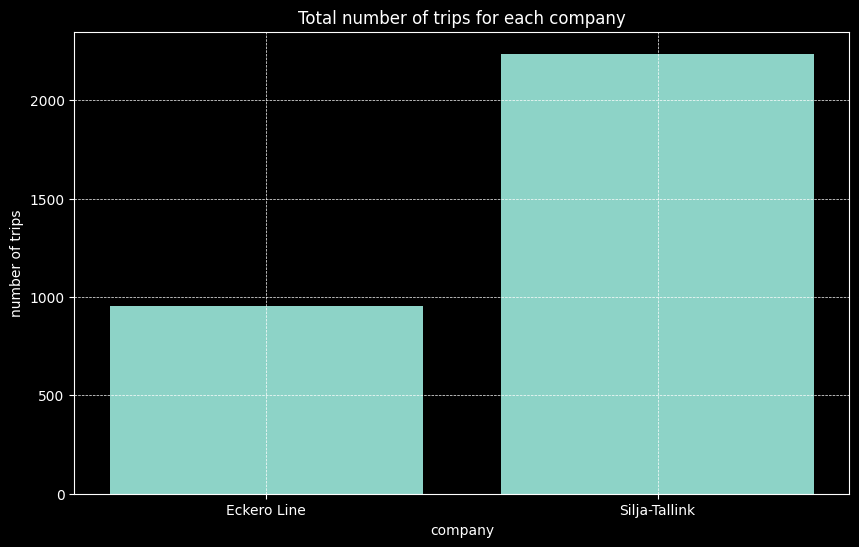

In [9]:
## 3. Generating plots

# 3.1 bar plot of total number of trips for each company - the companies are Eckero Line (Finlandia) and Silja-Tallink (Megastar, Star, Europa) 

plotting_df1 = monthly_instances.copy()
plotting_df1['company'] = plotting_df1['ship'].apply(lambda x: 'Eckero Line' if x == 'Finlandia' else 'Silja-Tallink')

plotting_df1 = plotting_df1.groupby('company')['trips'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(plotting_df1['company'], plotting_df1['trips'])
ax.set_xlabel('company')
ax.set_ylabel('number of trips')
ax.set_title('Total number of trips for each company')
ax.grid(True)

if save_output:
    fig.savefig(os.path.join(cwd, '..', 'results', 'figures', 'total_trips_per_company.png'), format='png', dpi=300)

plt.show()

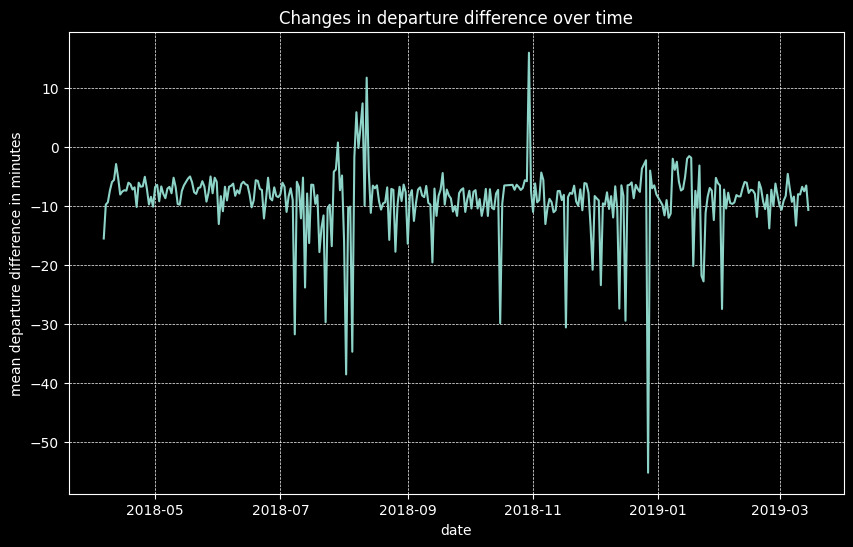

In [10]:
# 3.2 changes in the difference between etd and atd over time, considering outliers
performance_df2 = performance_df.copy()
performance_df2['departurediff_zscore'] = zscore(performance_df2['departure_diff'])

# 3.3 filter out the outliers
performance_df2 = performance_df2[performance_df2['departurediff_zscore'].abs() <= 3]
performance_df2['atd_date'] = performance_df2['atd'].dt.date
departure_diff_mean = performance_df2.groupby('atd_date')['departure_diff'].mean()

# 3.4 plot the changes over time
fig, ax = plt.subplots(figsize=(10, 6)) 
#ax.scatter(performance_df2['atd_date'], performance_df2['departure_diff'], s=5, label='Individual departure differences')
ax.plot(departure_diff_mean.index, departure_diff_mean.values)
ax.set_xlabel('date')
ax.set_ylabel('mean departure difference in minutes')
ax.set_title('Changes in departure difference over time')
ax.grid(True)

if save_output:
    fig.savefig(os.path.join(cwd, '..', 'results', 'figures', 'departure_diff_over_time.png'), format='png', dpi=300)

plt.show()

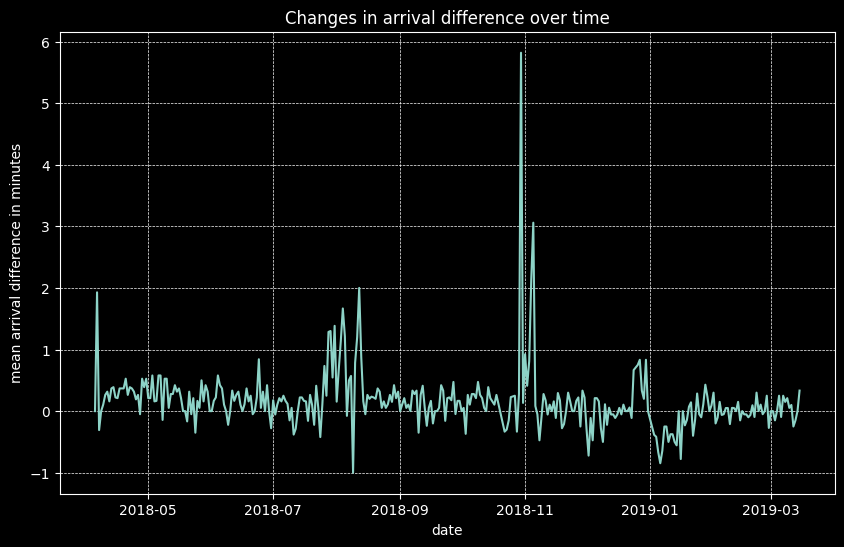

In [11]:
# 3.5 Changes in the difference between eta and ata over time

performance_df3 = performance_df.copy()
performance_df3['arrivaldiff_zscore'] = zscore(performance_df3['arrival_diff'])

# 3.6 filter out the outliers
filtered_df2 = performance_df3[performance_df3['arrivaldiff_zscore'].abs() <= 3]
filtered_df2['ata_date'] = filtered_df2['ata'].dt.date
arrival_diff_mean = filtered_df2.groupby('ata_date')['arrival_diff'].mean()

# 3.7 plot the changes over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(arrival_diff_mean.index, arrival_diff_mean.values)
ax.set_xlabel('date')
ax.set_ylabel('mean arrival difference in minutes')
ax.set_title('Changes in arrival difference over time')
ax.grid(True)

if save_output:
    fig.savefig(os.path.join(cwd, '..', 'results', 'figures', 'arrival_diff_over_time.png'), format='png', dpi=300)

plt.show()

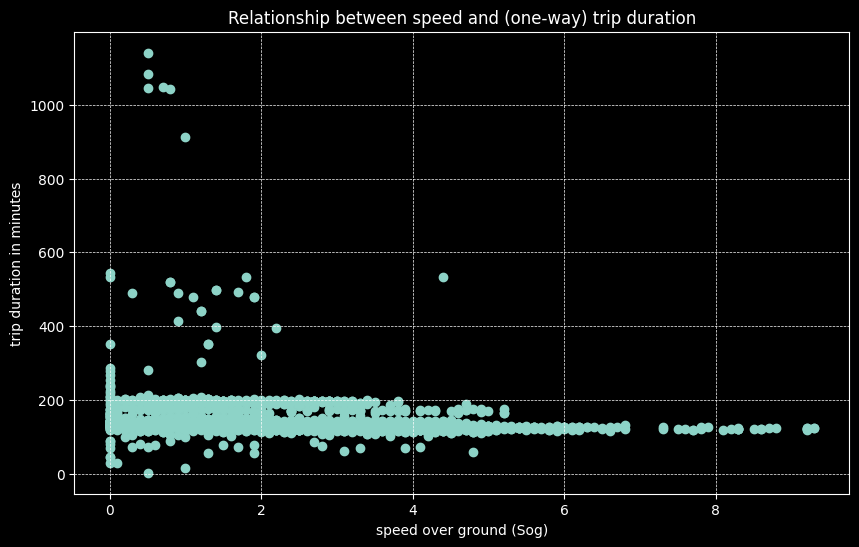

In [12]:
# 3.8 relationship between 'Sog' (Speed over Ground) and the trip duration

performance_df4 = performance_df.copy()
performance_df4['duration'] = (performance_df4['ata'] - performance_df4['atd']).dt.total_seconds() / 60
# 3.9 filter out speeds over 15
performance_df4 = performance_df4.loc[performance_df4['sog'] <= 15]
# 3.10 create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(performance_df4['sog'], performance_df4['duration'])
ax.set_xlabel('speed over ground (Sog)')
ax.set_ylabel('trip duration in minutes')
ax.set_title('Relationship between speed and (one-way) trip duration')
ax.grid(True)

if save_output:
    fig.savefig(os.path.join(cwd, '..', 'results', 'figures', 'sog_vs_duration.png'), format='png', dpi=300)

plt.show()

Around 2 and 3 hours seems to be the normal duration. Speed over ground looks weird and should be explored further if we wish to utilize it somehow - maybe we could check if possible to get avg speeds between actual departure and arrival. Does not seem to offer much here.

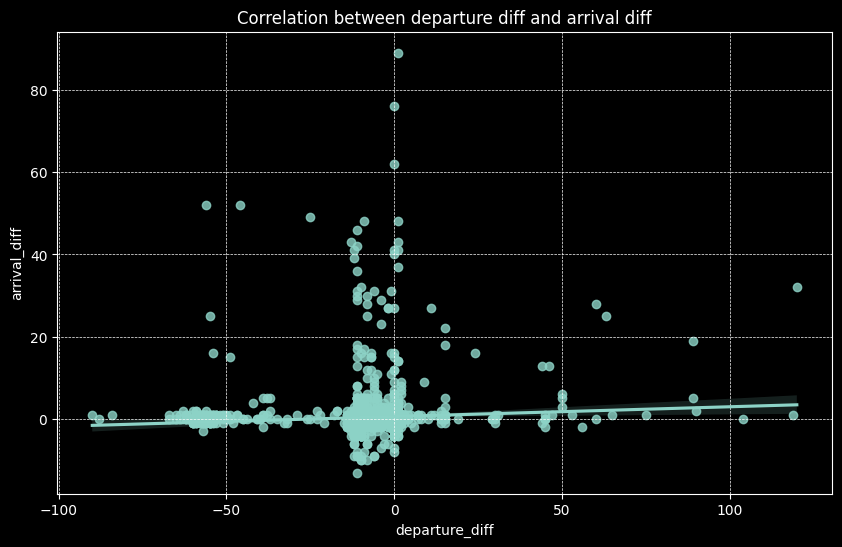

In [13]:
# 3.11  scatter plot with a best-fit line to depict the correlation between delay in departure (atd - etd) and delay in arrival (ata - eta)
performance_df5 = performance_df.copy()

threshold = 120 # (minutes)
performance_df5 = performance_df5[(performance_df5['departure_diff'].abs() <= threshold) & 
                                  (performance_df5['arrival_diff'].abs() <= threshold)]

# 3.12 plot scatter and best fit line
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='departure_diff', y='arrival_diff', data=performance_df5, ax=ax)
ax.set_title('Correlation between departure diff and arrival diff')
ax.grid(True)

if save_output:
    fig.savefig(os.path.join(cwd, '..', 'results', 'figures', 'departure_vs_arrival_diff.png'), format='png', dpi=300)

plt.show()

# Task 3 end

Seems to be a very slight correlation - the best fit line is almost flat. A steeper slope would generally imply that the changes in the departure delay are more strongly associated with changes in the arrival delay. But here the ships are actually late (or the difference between estimated and true arrival times is bigger) more often when the actual departure is close to the estimate. It seems that other factors, such as weather, play a bigger role and the **arrival estimate is made when the ship actually departs: the delay in departure is accounted for in the arrival estimate** - though the data may also be at least partially faulty. Hence, we can conclude that the arrival delay is mostly independent of the departure delay.

It should be noted that the estimated times, not the scheduled times, are used in computing the differences. Exploring the relationships using the scheduled times could also offer interesting insights - probably a steeper upward slope, that is, stronger association.

Regarding the scatter, there seems to be a bunch of departures about an hour earlier than the estimated departure time. One can wonder if this relates to the fact that etd is estimated by FinEstAPI, maybe some estimation errors there. Maybe related to Daylight Saving Time.

 Maybe we could check again while limiting the departure_diff to a smaller window. A 10 minute departure window could be fine to get a look at a more "normal" scenario and get rid of the possibly faulty parts.

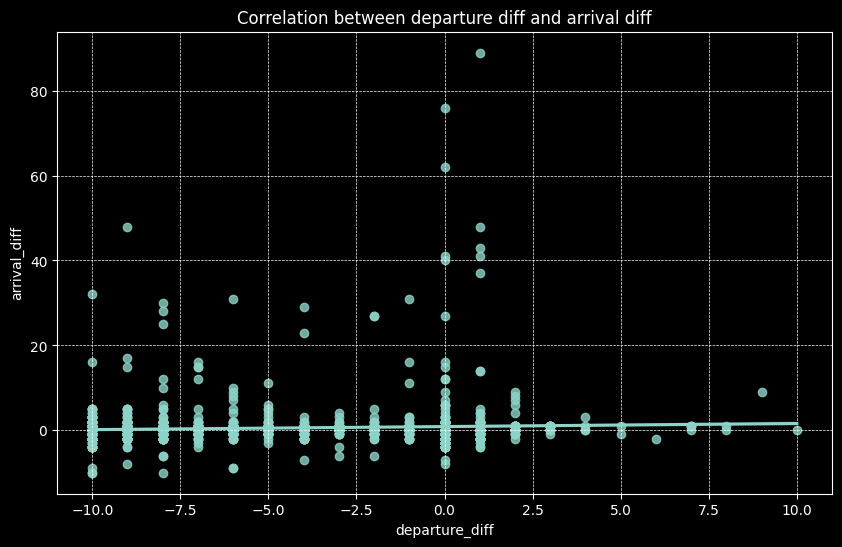

In [14]:
## 4. Additional exploration

performance_df6 = performance_df.copy()

# 4.1 10 min departure window
threshold = 90 # (minutes)
performance_df6 = performance_df6[(performance_df6['departure_diff'].abs() <= 10) & 
                                  (performance_df6['arrival_diff'].abs() <= threshold)]

fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='departure_diff', y='arrival_diff', data=performance_df6, ax=ax)
ax.set_title('Correlation between departure diff and arrival diff')
ax.grid(True)

if save_output:
    fig.savefig(os.path.join(cwd, '..', 'results', 'figures', 'departure_vs_arrival_diff2.png'), format='png', dpi=300)

plt.show()

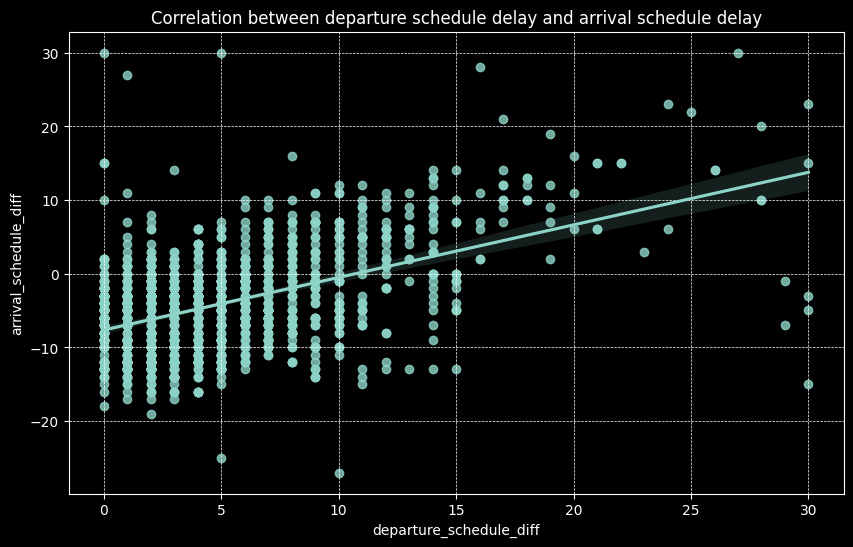

In [15]:
# 4.2 exploring departure schedule delay and arrival schedule delay, namely ships leaving after their scheduled departure times

performance_df7 = performance_df.copy()

threshold = 30 # (minutes)
performance_df7 = performance_df7[(performance_df7['departure_schedule_diff'] >= 0) & 
                                  (performance_df7['departure_schedule_diff'] <= threshold) & 
                                  (performance_df7['arrival_schedule_diff'].abs() <= threshold)]


fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='departure_schedule_diff', y='arrival_schedule_diff', data=performance_df7, ax=ax)
ax.set_title('Correlation between departure schedule delay and arrival schedule delay')
ax.grid(True)

if save_output:
    fig.savefig(os.path.join(cwd, '..', 'results', 'figures', 'departure_vs_arrival_delay3.png'), format='png', dpi=300)

plt.show()

Here we can more clearly see with the schedule differences and 30min thresholds that ships leaving late tend to also arrive late. That is, these differences are somewhat correlated.

**Additional metrics:** we could for example explore the effect of seasonality on delays. Also, if we wish to get more insights using more data, we could use historical weather data e.g. from The Finnish Meteorological Institute. Especially wind speed, and maybe humidity (fog), and such features would be interesting.